# F0 estimation using pyin 

*maelzel* uses the [pyin algorithm](https://ieeexplore.ieee.org/document/6853678) for fundamental frequency estimation. The best implementation of this algorithm is the pyin vamp plugin (https://code.soundsoftware.ac.uk/projects/pyin) which is included in the [vamp plugin pack](https://vamp-plugins.org/pack.html). **It is highly recommended to install it** when doing fundamental frequency analysis. As a fallback there is a pure python implementation included which renders good results but is **very slow** at the moment. 

In [1]:
from maelzel.snd import freqestimate, audiosample
import numpy as np

# Make plots larger
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 6)

Load a sample of Joyce reading. Gets the left channel (channel 0) and crops it to the first 10 seconds

Sample(dur=10.0, sr=44100, ch=1)
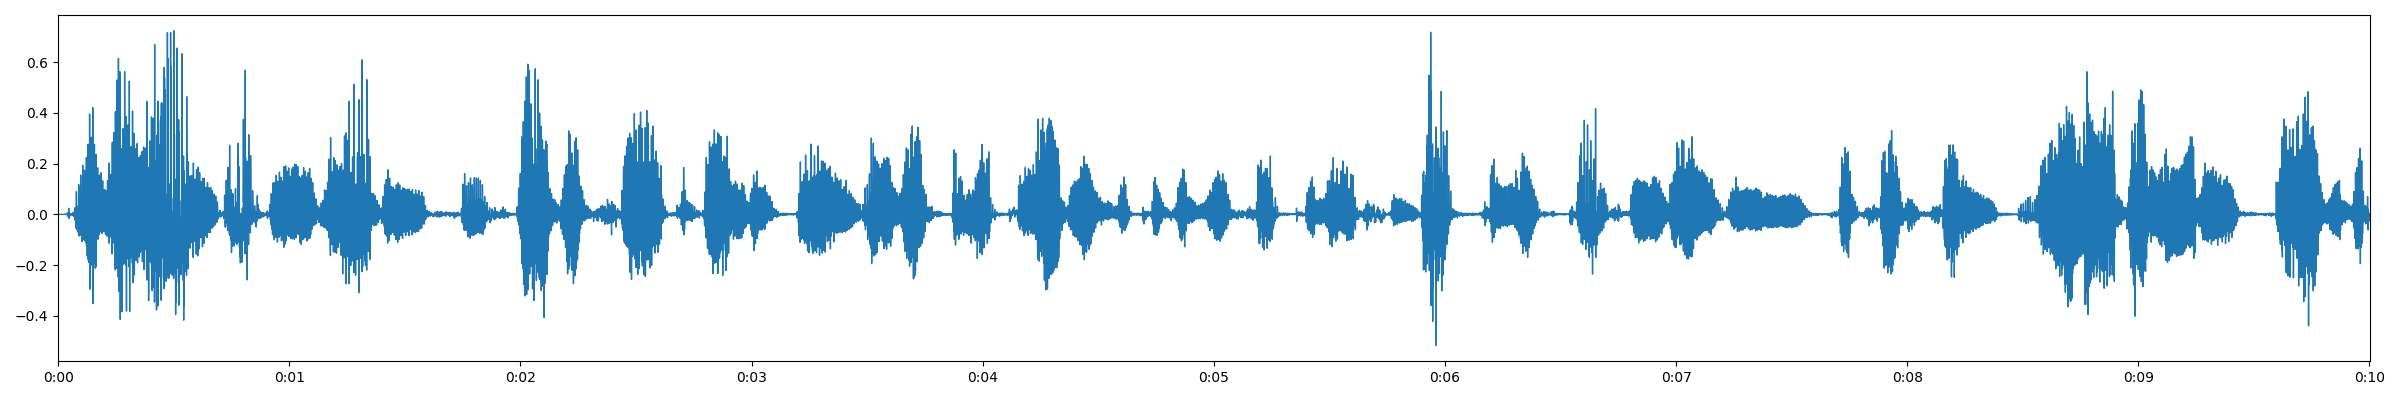

In [2]:
samp = audiosample.Sample("snd/finneganswake-fragm01.flac").getChannel(0, contiguous=True)[0:10]
samp

Estimate the fundamental using pyin

`f0curve` returns two [bpfs](https://bpf4.readthedocs.io); the first is the fundamental frequency curve, the second represents the voicedness (the probablity that the sound is harmonic) over time. Sounds with a clear pitch will have a high voicedness value. Whenever the sound is noisy or silent the voicedness value drops. 

In [3]:
freq, voiced = freqestimate.f0curve(sig=samp.samples, sr=samp.sr, method='pyin')

LibXtract compiled with ooura FFT


mnOut size: 862
m_pitchTrack size: 862


When plotting the fundamental frequency, the line might be broken at some places. That is because whenever the voicedness drops below a certain threshold no valid frequency can be estimated and a `nan` (not a number) is output instead. When plotting, such nans are not plotted, resulting in a fragmented line

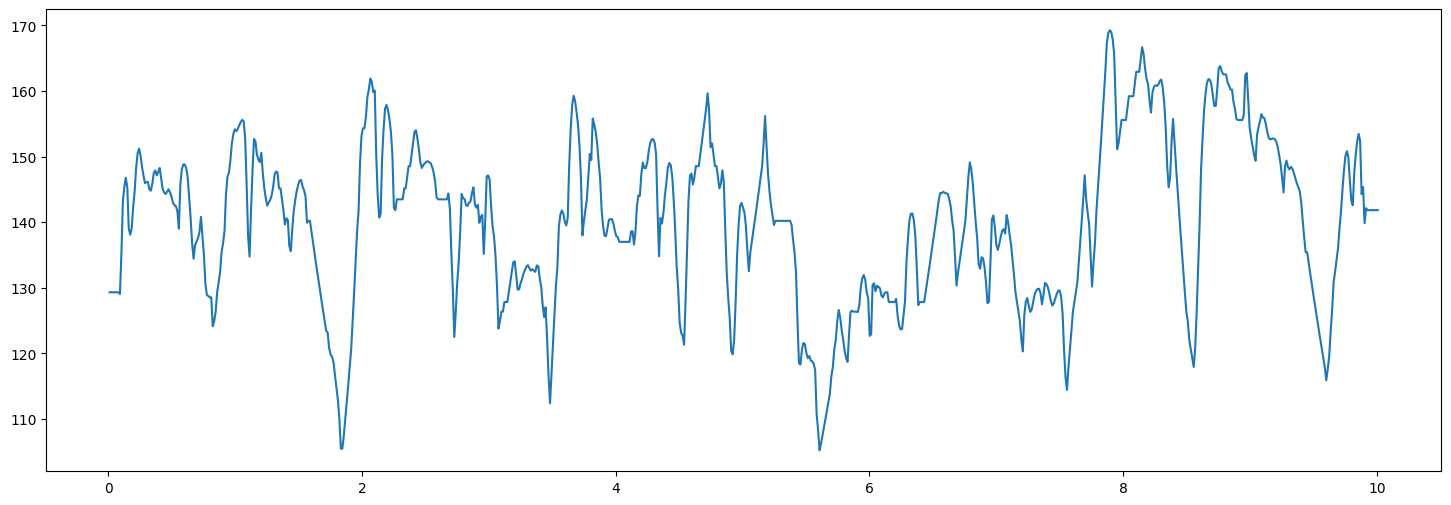

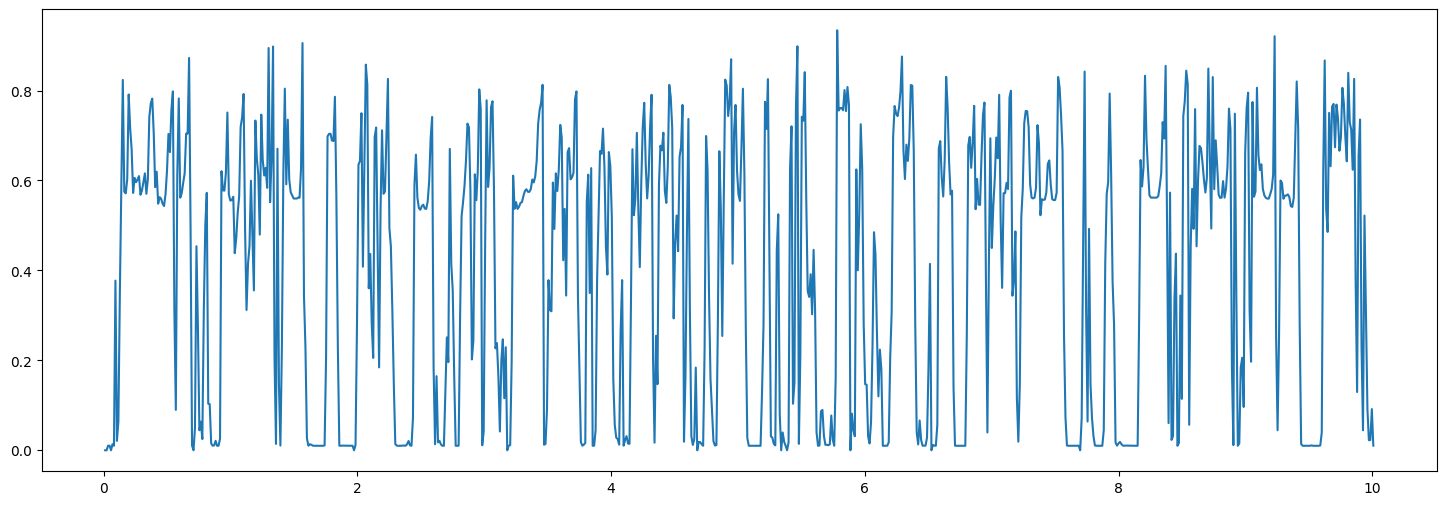

<Axes: >

In [4]:
freq.plot()
voiced.plot()

If detailed control over parameters of the pyin analysis is needed it is possible to use the specific function for the pyin vamp method. For example, here we supress low amplitudes. Notice how some fragments are missing

mnOut size: 862
m_pitchTrack size: 862


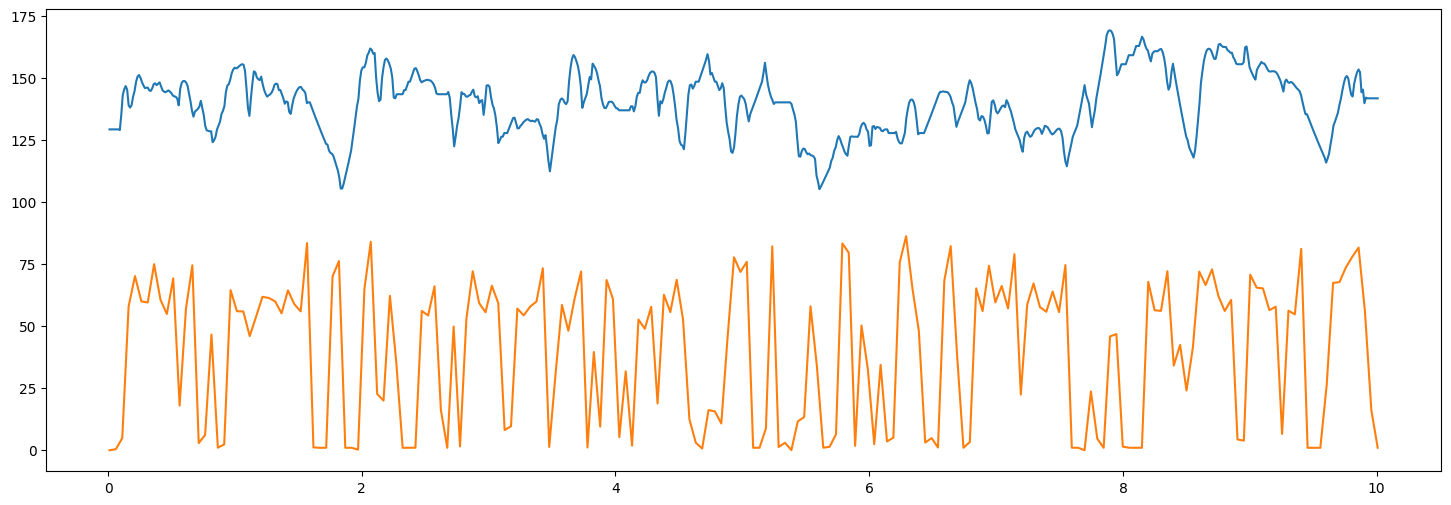

<Axes: >

In [5]:
freq2, voiced2 = freqestimate.f0curvePyinVamp(samp.samples, samp.sr, fftsize=2048, overlap=4, pruneThreshold=0.1, threshDistr='beta15', 
                                              onsetSensitivity=0.1, unvoicedFreqs='nan')
axes = freq2.plot(show=False)
(voiced2 *  100).plot(axes=axes)


For amplitude tracking we can use the peak values (see `Sample.peaksbpf`). Also possible would be to use rms via `Sample.rmsbpf`

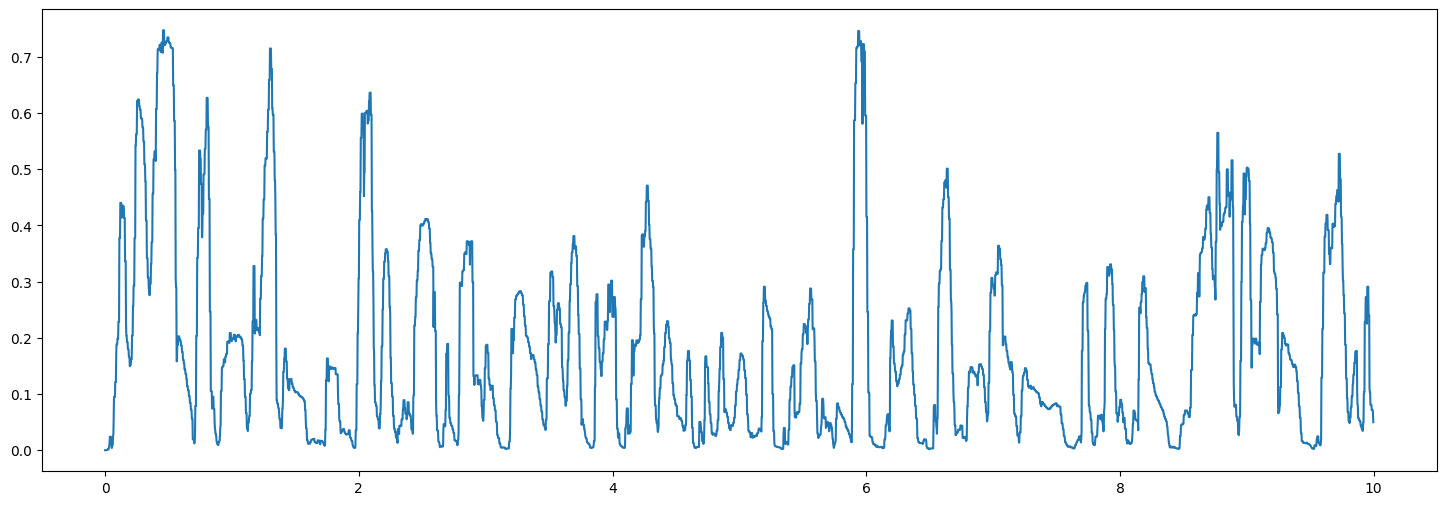

<Axes: >

In [6]:
peakamp = samp.peaksBpf(overlap=4)
peakamp.plot()

-----------

### Playback

In order to play the original sound and the estimated fundamental in sync we create a sound engine to be used for both

In [7]:
import csoundengine as ce
e = ce.Engine(nchnls=2)
s = e.session()


--Csound version 7.0 (double samples) May  8 2025
[commit: 16c1c7b91a592a81434031853eea941ed759abdb]
libsndfile-1.2.2
sr = 48000.0, kr = 750.000, ksmps = 64
0dBFS level = 1.0, A4 tuning = 440.0
audio buffered in 256 sample-frame blocks
reading 2048-byte blks of shorts from adc:Built-in Audio Analog Stereo: (RAW)
writing 512 sample blks of 64-bit floats to dac:Built-in Audio Analog Stereo:
SECTION 1:


Now we extract the individual points of the bpfs in order to transfer them to the sound engine. Notice that in the case of frequencies the `nan`s need to be replaced with other values for the sound engine to be able to handle them properly

In [8]:
times, freqs = freq.points()
_, voicedvalues = voiced.points()
delay = times[0]
times -= times[0]
dur = times[-1]

# Replace nans with -1
freqs[np.isnan(freqs)] = -1

For each array we create a table in csound

In [9]:
tabtimes = s.makeTable(times)
tabfreqs = s.makeTable(freqs)
peakamps = s.makeTable(peakamp.map(times))


To play back the estimated frequency we create a simple csound instrument. It gets the tables (tables are 1D arrays in csound) holding the times, frequencies and amplitudes and interpolates to generate instantaneous values for both frequency and amplitude. Whenever the frequency is negative it is considered invalid and the sound is muted. The amplitude tracked from the original sound is used to drive the oscillator.

In [10]:
s.defInstr('osc', r'''
|itimestab, ifreqstab, iampstab, igain=1, iamplag=0.01|
; itimestab: the times table
; ifreqstab: the frequencies table
; iampstab: the ampltiudes table
; igain: a gain facotr
; iamplag: a lag time for the amplitude gate

prints "itimestab: %d, ifreqstab: %d, iampstab: %d\n", itimestab, ifreqstab, iampstab

kt = timeinsts:k()                   ; elapsed time
kidx = bisect:k(kt, itimestab)       ; find index into the times table
kfreq0 = interp1d:k(kidx, ifreqstab) ; interpolate a frequency value
kisvalid = kfreq0 >= 0 ? 1 : 0       ; is the value valid?
kfreq = samphold:k(kfreq0, kisvalid) ; if valid, use the value, otherwise keep the old valid value
kamp = interp1d:k(kidx, iampstab)    ; interpolate amplitude
kgate = kisvalid*igain               ; if valid, open the gate
aenv = lag:a(interp(kgate), iamplag) ; convert the gate to an envelope

a0 = vco2:a(kamp, kfreq) * aenv      ; a sawtooth oscil
outch 1, a0                          ; output oscil to channel 1
''')

Instr(osc, itimestab=0, ifreqstab=0, iampstab=0, igain=1, iamplag=0.01)

Now we play the original sample in sync with the estimated fundamental. 

In [13]:
# Share the data with the audio engine. This operation is cached so calling makeTable with
# the same array multiple times has no side effects, a new table is created only if the
# data changes
samptable = s.makeTable(samp.samples, sr=samp.sr)

# To ensure synchronicity between events we schedule the events with the engine clock locked
# This makes sure that the scheduling operation itself does not cause timing problems

with e.lockedClock():
    s.playSample(samptable, pan=1)
    s.sched('osc', delay=delay, dur=dur, 
            args=dict(itimestab=tabtimes.tabnum, ifreqstab=tabfreqs.tabnum, iampstab=peakamps.tabnum, igain=0.3, iamplag=0.05))
    


itimestab: 101, ifreqstab: 102, iampstab: 103


In [14]:
# Notice that pfields can also be given as keyword arguments: 

with e.lockedClock():
    s.playSample(samptable, pan=1)
    s.sched('osc', delay=delay, dur=dur, 
            itimestab=tabtimes, ifreqstab=tabfreqs, iampstab=peakamps, igain=0.3, iamplag=0.05)
            

itimestab: 101, ifreqstab: 102, iampstab: 103
